In [55]:
from datetime import datetime
import numpy as np
import os
os.environ['MPLCONFIGDIR'] = "/wrk-vakka/users/hajaalin/tmp_mplconfigdir"
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from pathlib import Path
import shap
import sys



In [56]:
#shap_root = Path('/proj/group/lmu/projects/n_track_ML/output/shap/save_X_test_f_dxy_mindist_angle_area_20221103/202211030938/')
#shap_root = Path('/wrk/group/lmu/projects/n_track_ML/output/shap/save_X_test2_f_dxy_mindist_angle_area_20221103/202211031451/')
#shap_root = Path('/wrk-vakka/group/lmu/projects/n_track_ML/output/shap/fix_sgkf_all_20221117/202211171739')
shap_root = Path('/wrk-vakka/group/lmu/projects/n_track_ML/output/shap/fix_sgkf_all_20221118/202211180940')
glob3 = shap_root.glob('*/train_index_list.npy')
glob4 = shap_root.glob('*/accuracy_list.npy')
  
load_train_index_list = []
for g in glob3:
    #print(str(g))
    load_train_index_list.extend(np.load(g, allow_pickle=True))

load_accuracy_list = []
for g in glob4:
    #print(str(g))
    load_accuracy_list.extend(np.load(g, allow_pickle=True))



In [57]:
print(len(load_train_index_list))
print(load_train_index_list[0].shape)
print(len(load_accuracy_list))
print(load_accuracy_list[0].shape)


10000
(222,)
10000
()


## Histogram of accuracy

In [58]:
load_train_index_list[0]

array([  2,   3,   4,   5,   7,  10,  11,  12,  13,  16,  17,  18,  19,
        20,  21,  24,  25,  26,  27,  28,  29,  32,  33,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  68,
        69,  72,  73,  74,  75,  78,  79,  80,  81,  82,  83,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 118, 119,
       120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 131, 132, 135,
       136, 137, 138, 139, 140, 143, 144, 145, 146, 149, 150, 151, 152,
       153, 154, 155, 156, 159, 160, 161, 162, 163, 164, 166, 167, 168,
       169, 171, 172, 173, 174, 175, 178, 179, 180, 181, 182, 183, 184,
       185, 188, 189, 190, 191, 194, 195, 196, 197, 198, 201, 202, 203,
       204, 205, 206, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
       221, 222, 225, 226, 227, 228, 229, 230, 231, 232, 233, 23

(array([1.000e+00, 0.000e+00, 3.000e+00, 4.000e+00, 6.000e+00, 1.100e+01,
        9.000e+00, 2.300e+01, 3.300e+01, 5.000e+01, 6.700e+01, 1.080e+02,
        1.390e+02, 1.850e+02, 1.950e+02, 1.880e+02, 1.830e+02, 2.200e+02,
        2.280e+02, 1.750e+02, 1.740e+02, 1.280e+02, 9.900e+01, 9.600e+01,
        6.300e+01, 5.000e+01, 3.300e+01, 2.400e+01, 2.300e+01, 2.000e+01,
        2.600e+01, 2.000e+01, 3.700e+01, 4.900e+01, 6.400e+01, 9.100e+01,
        1.130e+02, 1.580e+02, 1.730e+02, 2.130e+02, 2.520e+02, 3.370e+02,
        4.350e+02, 4.640e+02, 5.380e+02, 6.120e+02, 7.310e+02, 8.810e+02,
        1.049e+03, 1.219e+03]),
 array([0.34722222, 0.36027778, 0.37333333, 0.38638889, 0.39944444,
        0.4125    , 0.42555556, 0.43861111, 0.45166667, 0.46472222,
        0.47777778, 0.49083333, 0.50388889, 0.51694444, 0.53      ,
        0.54305556, 0.55611111, 0.56916667, 0.58222222, 0.59527778,
        0.60833333, 0.62138889, 0.63444444, 0.6475    , 0.66055556,
        0.67361111, 0.68666667, 0.69

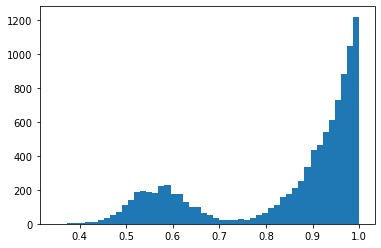

In [59]:
accuracy = np.array(load_accuracy_list)
plt.hist(accuracy, bins=50)

## Limits for hi and lo accuracy models
25% seems to be a good pick. The least accurate 25% accounts for the bump centered at 0.57 or so.

In [60]:
acc_lo = np.percentile(accuracy, 25)
acc_hi = np.percentile(accuracy, 75)
print(acc_lo)
print(acc_hi)


0.716367486889875
0.972972972972973


In [61]:
load_train_index_list[0]

array([  2,   3,   4,   5,   7,  10,  11,  12,  13,  16,  17,  18,  19,
        20,  21,  24,  25,  26,  27,  28,  29,  32,  33,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  68,
        69,  72,  73,  74,  75,  78,  79,  80,  81,  82,  83,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 118, 119,
       120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 131, 132, 135,
       136, 137, 138, 139, 140, 143, 144, 145, 146, 149, 150, 151, 152,
       153, 154, 155, 156, 159, 160, 161, 162, 163, 164, 166, 167, 168,
       169, 171, 172, 173, 174, 175, 178, 179, 180, 181, 182, 183, 184,
       185, 188, 189, 190, 191, 194, 195, 196, 197, 198, 201, 202, 203,
       204, 205, 206, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
       221, 222, 225, 226, 227, 228, 229, 230, 231, 232, 233, 23

In [62]:
load_train_index_list[1].shape

(213,)

In [63]:
accuracy > acc_hi


array([False, False, False, ..., False,  True,  True])

## Convert training set index in binary format
[1,3,4,7,...] -> [1,0,1,1,0,0,1,...]

In [64]:
def index_to_boolean(integer_index):
    idx = np.zeros(289)
    for i in integer_index:
        idx[i] = 1
    return idx

index_list = []
for index in load_train_index_list:
    index_list.append(index_to_boolean(index))

index_list = np.array(index_list)
index_list.shape

(10000, 289)

## Sum over repetitions to see how many times a sequence appears in the training set
### First all repetitions...

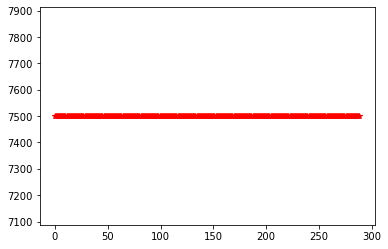

In [65]:
index_sums = np.sum(index_list, axis=(0) )
plt.plot(index_sums, '*', color='r')


### ... and then repetitions that ended up with a hi or lo accuracy model

In [66]:
index_list_hi = index_list[ accuracy > acc_hi ]
index_list_lo = index_list[ accuracy < acc_lo ]
index_sums_hi = np.sum(index_list_hi, axis=(0))
index_sums_lo = np.sum(index_list_lo, axis=(0))


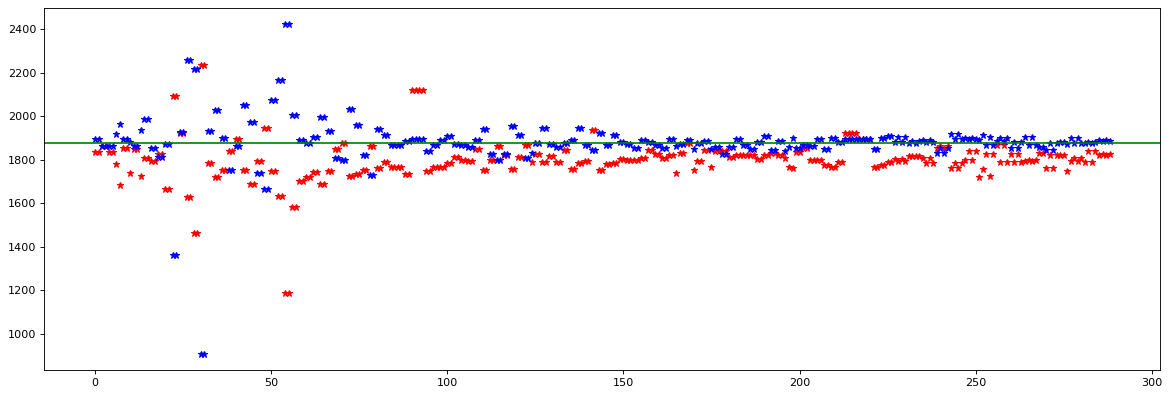

In [67]:
plt.figure(figsize = (18, 6), dpi = 80)
plt.plot(index_sums_hi, '*', color='r')
plt.plot(index_sums_lo, '*', color='b')
plt.axhline(y = 1875, color = 'g', linestyle = '-')
#plt.plot(7500/4)

In [68]:
diff_sums = index_sums_hi - index_sums_lo

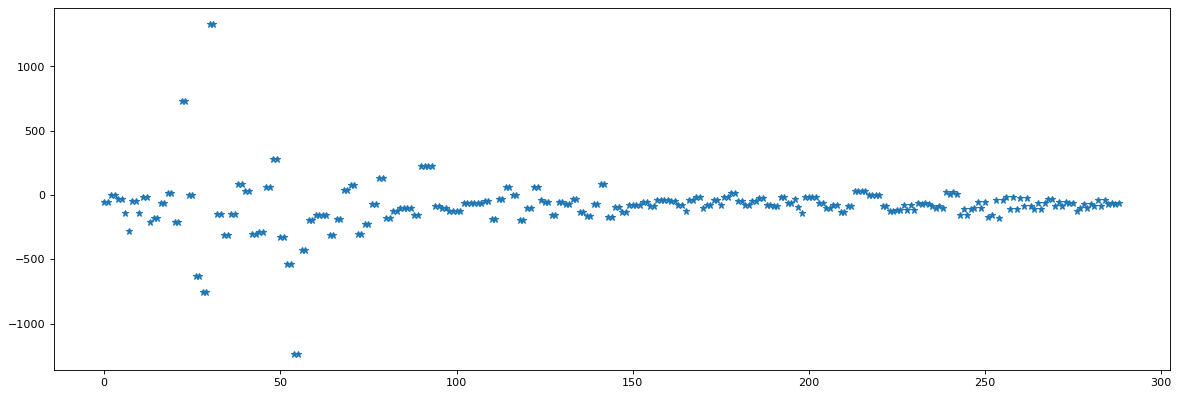

In [69]:
plt.figure(figsize = (18, 6), dpi = 80)
plt.plot(diff_sums, '*')

In [70]:
7500/4

1875.0

In [71]:
img_sums_hi = index_sums_hi.copy()
img_sums_lo = index_sums_lo.copy()
print(np.min(img_sums_hi))
print(np.min(img_sums_lo))
min(np.min(img_sums_hi), np.min(img_sums_lo))

1187.0
907.0


907.0

In [72]:
img_sums_hi = index_sums_hi.copy()
img_sums_lo = index_sums_lo.copy()
sum_min = min(np.min(img_sums_hi), np.min(img_sums_lo))
sum_max = max(np.max(img_sums_hi), np.max(img_sums_lo))
print(sum_min)
print(sum_max)
img_sums_hi = (img_sums_hi - sum_min) / sum_max
img_sums_lo = (img_sums_lo - sum_min) / sum_max
img_sums_hi.resize(300)
img_sums_lo.resize(300)
img_sums_hi = img_sums_hi.reshape((15,20))
img_sums_lo = img_sums_lo.reshape((15,20))

# https://stackoverflow.com/questions/10443295/combine-3-separate-numpy-arrays-to-an-rgb-image-in-python
r = img_sums_hi
g = np.zeros((15,20))
b = img_sums_lo

rgb = np.dstack((r,g,b))
rgb_uint8 = (np.dstack((r,g,b)) * 255.999) .astype(np.uint8)

907.0
2422.0


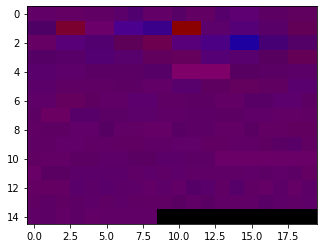

In [73]:
#plt.imshow(rgb_uint8)
#plt.rcParams["figure.figsize"] = (15,20)
plt.imshow(rgb)


In [74]:
ish = index_sums_hi[index_sums_hi > 1875]

In [75]:
ish.shape

(24,)

# Fold accuracy

For some reason, fold 1/4 seems to consistently result in lower accuracy. 
- Something wrong with StratifiedGroupKFold? Test with KFold to compare.

## Accuracy of folds 1-4, 2500 repetitions

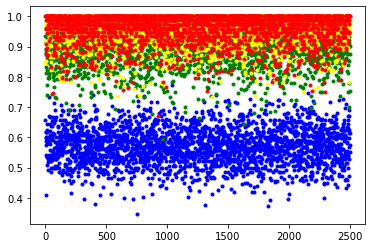

In [76]:
accarr = np.array(load_accuracy_list)
a1 = accarr[0:9999:4]
a2 = accarr[1:9999:4]
a3 = accarr[2:9999:4]
a4 = accarr[3:9999:4]
plt.plot(a1,'.', color='blue')
plt.plot(a2,'.', color='green')
plt.plot(a3,'.', color='yellow')
plt.plot(a4,'.', color='red')

## How often an instance ended up in a particular fold?
- Why not uniform throughout?

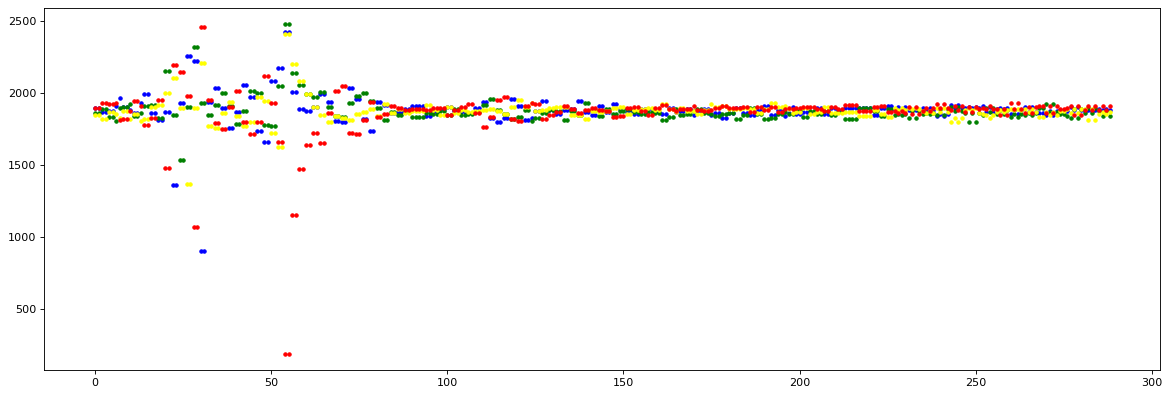

In [77]:

index_sums = np.sum(index_list, axis=(0) )
index_sums1 = np.sum(index_list[0:9999:4], axis=(0) )
index_sums2 = np.sum(index_list[1:9999:4], axis=(0) )
index_sums3 = np.sum(index_list[2:9999:4], axis=(0) )
index_sums4 = np.sum(index_list[3:9999:4], axis=(0) )
plt.figure(figsize = (18, 6), dpi = 80)
#plt.plot(index_sums, '.', color='black')
plt.plot(index_sums1, '.', color='blue')
plt.plot(index_sums2, '.', color='green')
plt.plot(index_sums3, '.', color='yellow')
plt.plot(index_sums4, '.', color='red')


## Fold 1 is practically identical with the least accurate 25%

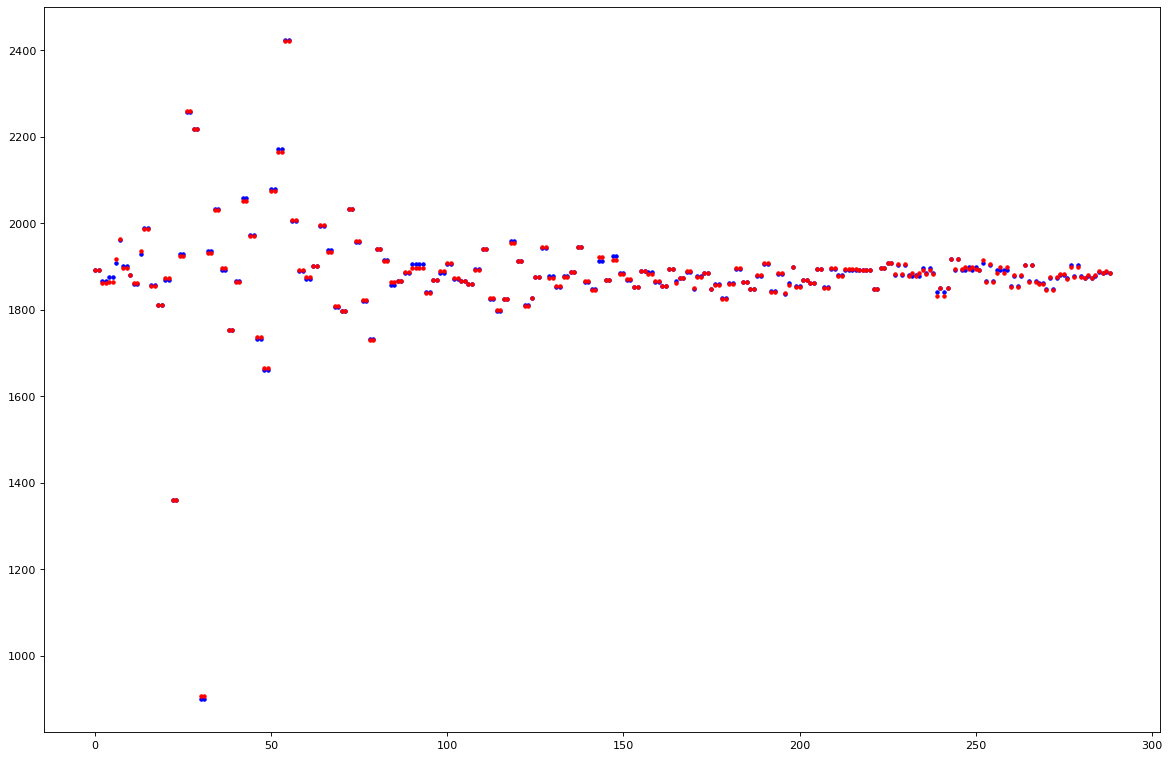

In [78]:
plt.figure(figsize = (18, 12), dpi = 80)
plt.plot(index_sums1, '.', color='blue')
plt.plot(index_sums_lo, '.', color='red')


In [79]:
print(index_list.shape)
print(index_list[0:9999:4].shape)
print(index_list[1:9999:4].shape)
print(index_list[2:9999:4].shape)
print(index_list[3:9999:4].shape)


(10000, 289)
(2500, 289)
(2500, 289)
(2500, 289)
(2499, 289)


In [80]:
## Class distribution

In [81]:
y = np.load('/wrk-vakka/group/lmu/projects/n_track_ML/output/shap/shap_inceptiontime/20221117140251/y_mean.npy')
print(y.shape)
print(y)

(289,)
[0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 0 1 1 1
 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 1
 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1
 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 0 1]


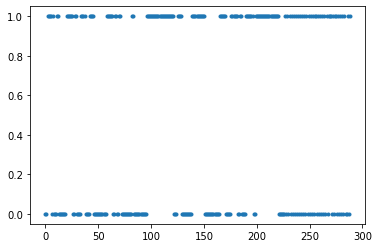

In [82]:
plt.plot(y, '.')

In [83]:
ti1 = load_train_index_list[0:9999:4]
ti2 = load_train_index_list[1:9999:4]
ti3 = load_train_index_list[2:9999:4]
ti4 = load_train_index_list[3:9999:4]


In [84]:
ti1[0].shape

(222,)

In [85]:
ti2[1].shape

(217,)

In [86]:
import warnings
warnings.filterwarnings('ignore')
indices = pd.DataFrame()
for i in range(499):
    splits = []
    splits.append(pd.Series(ti1[i]))
    splits.append(pd.Series(ti2[i]))
    splits.append(pd.Series(ti3[i]))
    splits.append(pd.Series(ti4[i]))
    all_splits = pd.concat(splits, ignore_index=True)
    indices[str(i)] = all_splits


In [87]:
indices.shape

(867, 499)

In [88]:
4*0.75*289

867.0

In [89]:
indices.head()

,0,1,2,3,4,5,6,7,8,9,...,489,490,491,492,493,494,495,496,497,498
0,2,0,0,0,0,0,0,2,2,2,...,0,0,2,0,2,0,2,0,0,2
1,3,1,1,1,1,1,1,3,3,3,...,1,1,3,1,3,1,3,1,1,3
2,4,2,4,2,2,2,2,4,4,4,...,2,4,4,2,4,4,4,4,2,4
3,5,3,5,3,3,3,3,5,5,5,...,3,5,5,3,5,5,5,5,3,5
4,7,6,6,4,6,4,6,6,6,6,...,4,6,6,4,6,6,6,7,4,6


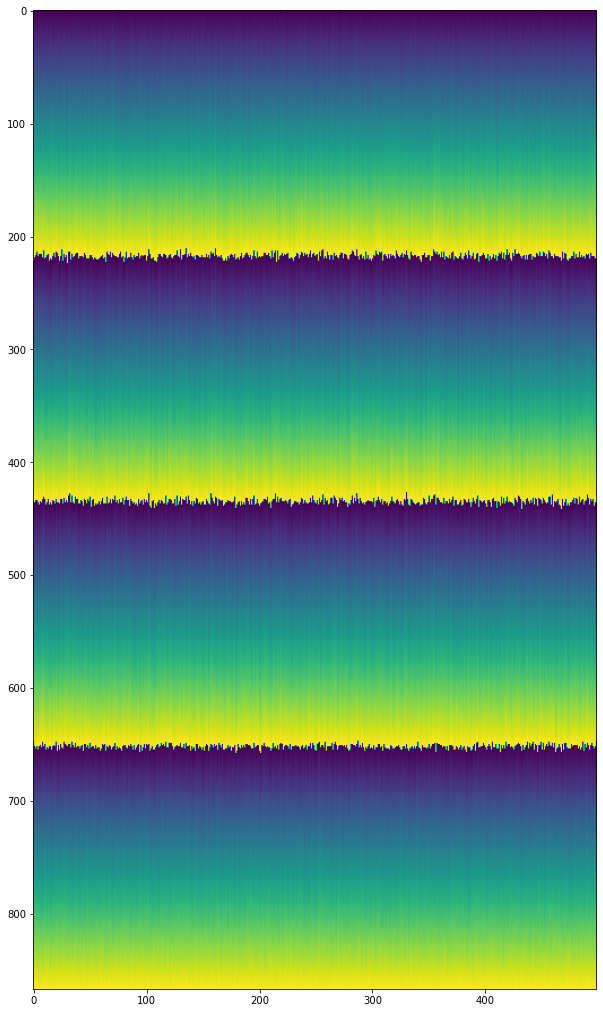

In [54]:
plt.figure(figsize = (18, 18))
plt.imshow(indices.values)

In [90]:
indices['0']

0        2
1        3
2        4
3        5
4        7
      ... 
862    284
863    285
864    286
865    287
866    288
Name: 0, Length: 867, dtype: int64

In [124]:
c1 = np.concatenate(ti1)
c2 = np.concatenate(ti2)
c3 = np.concatenate(ti3)
c4 = np.concatenate(ti4)
# repeats
nrepeats = 499
f1 = []
f2 = []
f3 = []
f4 = []
for i in range(289):
    f1.append(np.count_nonzero(c1 == i))
    f2.append(np.count_nonzero(c2 == i))
    f3.append(np.count_nonzero(c3 == i))
    f4.append(np.count_nonzero(c4 == i))
    

In [125]:
np.count_nonzero(c1==7)

1961

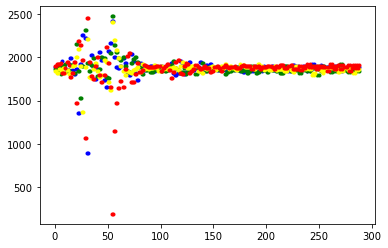

In [126]:
plt.plot(f1, '.', color='blue')
plt.plot(f2, '.', color='green')
plt.plot(f3, '.', color='yellow')
plt.plot(f4, '.', color='red')


In [101]:
4 * 0.75 * 289

867.0

In [107]:
 ti1a.shape

(2500,)

In [115]:
np.array(ti1a).shape

(2500,)

In [116]:
c1 = np.concatenate(ti1a)

In [117]:
np.cp

(544173,)